In [33]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from copy import deepcopy

[autoreload of Filters failed: Traceback (most recent call last):
  File "c:\Users\russe\Desktop\UKF-Variants\venv\lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\russe\Desktop\UKF-Variants\venv\lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
  File "C:\Program Files\Python310\lib\importlib\__init__.py", line 168, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module 'Filters'
]


In [34]:
import sys
sys.path.append("../filtering/")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import example_systems

car_system_gt = example_systems.kinematic_car_nonlinear

In [36]:
from filters import ExtendedKalmanFilter

# Define the approximate system model to be used by the filter
# in this case, our model has no mismatch with ground-truth system
car_system_approx = deepcopy(car_system_gt)

car_filter_EKF = ExtendedKalmanFilter(car_system_approx)

100%|██████████| 149/149 [00:00<00:00, 693.73it/s]


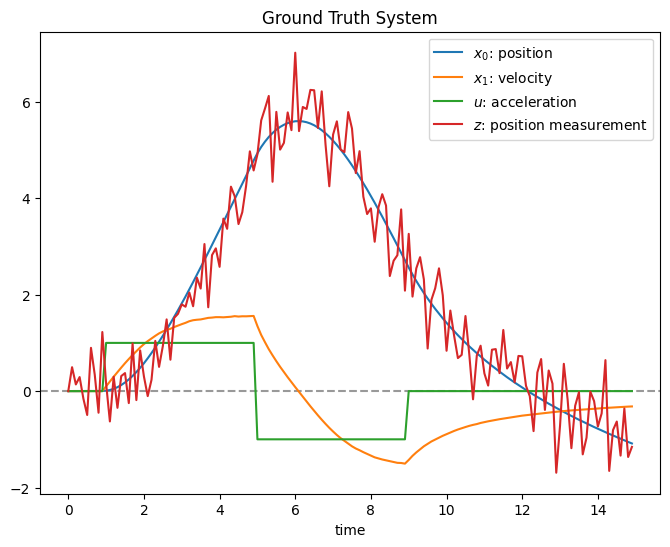

In [37]:
# Run the simulation

from helpers import vec

timesteps = np.arange(0.0, 15.0, step=car_system_gt.delta_t)
T = len(timesteps)

states_gt = np.zeros((T, 2, 1))
controls = np.zeros((T, 1, 1))

# initial position and velocity
states_gt[0] = vec(0, 0)

measurements = np.zeros((T, 1, 1))

# acceleration schedule
controls[10:50] = vec(1.0)
controls[50:90] = vec(-1.0)

for t in tqdm(range(1, T)):
    x = states_gt[t-1]
    u = controls[t]

    x_next = car_system_gt.query_dynamics_model(x, u)
    states_gt[t] = x_next

    z = car_system_gt.query_measurement_model(x)
    measurements[t] = z

# Plot results
plt.figure(figsize=(8, 6))
plt.title("Ground Truth System")
plt.xlabel("time")
plt.axhline(0, linestyle="--", color="gray", alpha=0.8)
plt.plot(timesteps, states_gt[:,0], label="$x_0$: position")
plt.plot(timesteps, states_gt[:,1], label="$x_1$: velocity")
plt.plot(timesteps, controls[:,0], label="$u$: acceleration")
plt.plot(timesteps, measurements[:,0], label="$z$: position measurement")
plt.legend()

In [38]:
# Test all filters with the same initial belief
initial_state_estimate = (
    vec(np.random.uniform(-1, 1), np.random.uniform(-1, 1)),     # initial mean
    np.array([      # initial covariance
        [0.1, 0.0],
        [0.0, 0.1]
    ])
)
initial_state_estimate

(array([[0.24276477],
        [0.5036472 ]]),
 array([[0.1, 0. ],
        [0. , 0.1]]))

100%|██████████| 149/149 [00:10<00:00, 14.04it/s]


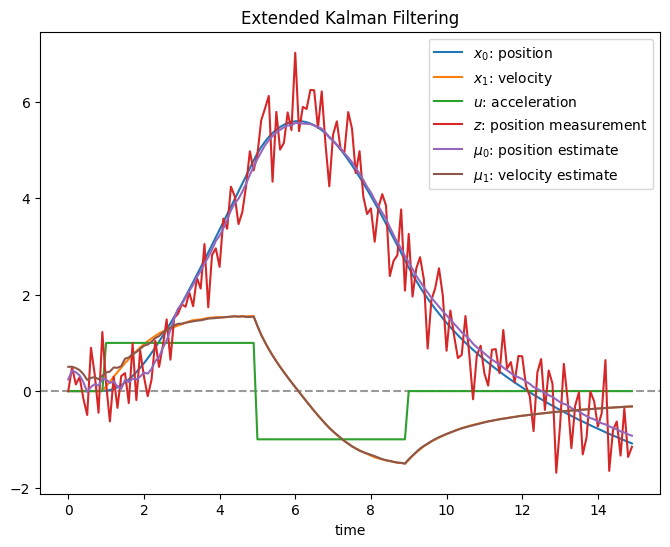

In [39]:
# Run the filter

# initial state belief
car_filter_EKF.initialize(*initial_state_estimate)

means_EKF = np.zeros((T, 2, 1))
covariances_EKF = np.zeros((T, 2, 2))

means_EKF[0] = car_filter_EKF.mean
covariances_EKF[0] = car_filter_EKF.covariance


for t in tqdm(range(1, T)):
    u = controls[t]
    z = measurements[t]

    car_filter_EKF.predict_step(u)
    car_filter_EKF.update_step(z)

    means_EKF[t] = car_filter_EKF.mean
    covariances_EKF[t] = car_filter_EKF.covariance


# Plot results
plt.figure(figsize=(8, 6))
plt.title("Extended Kalman Filtering")
plt.xlabel("time")
plt.axhline(0, linestyle="--", color="gray", alpha=0.8)
plt.plot(timesteps, states_gt[:,0], label="$x_0$: position")
plt.plot(timesteps, states_gt[:,1], label="$x_1$: velocity")
plt.plot(timesteps, controls[:,0], label="$u$: acceleration")
plt.plot(timesteps, measurements[:,0], label="$z$: position measurement")
plt.plot(timesteps, means_EKF[:,0], label="$\mu_0$: position estimate")
plt.plot(timesteps, means_EKF[:,1], label="$\mu_1$: velocity estimate")
plt.legend()

In [40]:
from filters import UnscentedKalmanFilter
from sigma_points import StandardSigmaPointSelector

# Define the approximate system model to be used by the filter
# in this case, our model has no mismatch with ground-truth system
car_system_approx = deepcopy(car_system_gt)

car_filter_UKF = UnscentedKalmanFilter(
    car_system_approx,
    sigma_point_selector=StandardSigmaPointSelector(alpha=0.2)
)

100%|██████████| 149/149 [00:01<00:00, 95.42it/s]


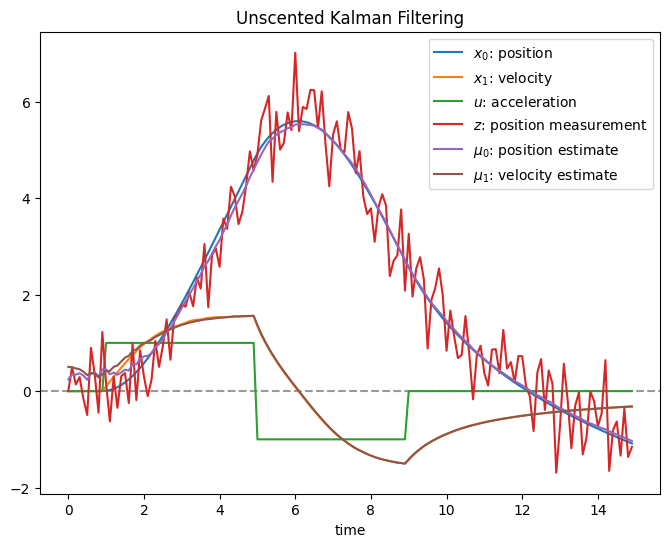

In [41]:
# Run the filter

# initial state belief
car_filter_UKF.initialize(*initial_state_estimate)

means_UKF = np.zeros((T, 2, 1))
covariances_UKF = np.zeros((T, 2, 2))

means_UKF[0] = car_filter_UKF.mean
covariances_UKF[0] = car_filter_UKF.covariance


for t in tqdm(range(1, T)):
    u = controls[t]
    z = measurements[t]

    car_filter_UKF.predict_step(u)
    car_filter_UKF.update_step(z)

    means_UKF[t] = car_filter_UKF.mean
    covariances_UKF[t] = car_filter_UKF.covariance


# Plot results
plt.figure(figsize=(8, 6))
plt.title("Unscented Kalman Filtering")
plt.xlabel("time")
plt.axhline(0, linestyle="--", color="gray", alpha=0.8)
plt.plot(timesteps, states_gt[:,0], label="$x_0$: position")
plt.plot(timesteps, states_gt[:,1], label="$x_1$: velocity")
plt.plot(timesteps, controls[:,0], label="$u$: acceleration")
plt.plot(timesteps, measurements[:,0], label="$z$: position measurement")
plt.plot(timesteps, means_UKF[:,0], label="$\mu_0$: position estimate")
plt.plot(timesteps, means_UKF[:,1], label="$\mu_1$: velocity estimate")
plt.legend()

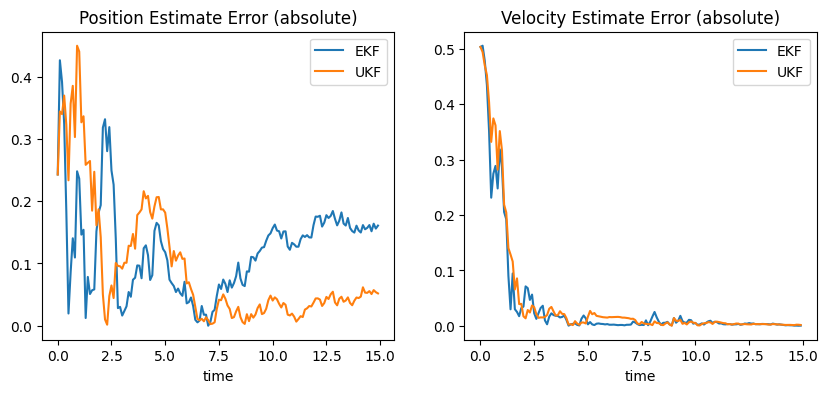

In [42]:
# Error analysis

errors_EKF = means_EKF - states_gt
errors_UKF = means_UKF - states_gt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.set_title("Position Estimate Error (absolute)")
ax1.set_xlabel("time")
ax1.plot(timesteps, np.abs(errors_EKF[:, 0]), label="EKF")
ax1.plot(timesteps, np.abs(errors_UKF[:, 0]), label="UKF")
ax1.legend()

ax2.set_title("Velocity Estimate Error (absolute)")
ax2.set_xlabel("time")
ax2.plot(timesteps, np.abs(errors_EKF[:, 1]), label="EKF")
ax2.plot(timesteps, np.abs(errors_UKF[:, 1]), label="UKF")
ax2.legend()